In [2]:
!pip install lightgbm


In [61]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os
import lightgbm as lgb
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [4]:
user_type = pd.read_csv('data/transaction_with_labels.csv')

In [5]:
user_type[(user_type.offer_type == 'informational') & (user_type.offer_received == 1) & (user_type.offer_viewed == 1)][['offer_type', 'offer_received', 'offer_viewed', 'received_viewed', 'amount_spent']]

,offer_type,offer_received,offer_viewed,received_viewed,amount_spent
14,informational,1,1,18.0,13.25
28,informational,1,1,0.0,1.72
41,informational,1,1,120.0,29.86
44,informational,1,1,0.0,2.63
59,informational,1,1,6.0,13.69
...,...,...,...,...,...
20895,informational,1,1,30.0,1.08
20908,informational,1,1,108.0,25.54
20909,informational,1,1,0.0,19.88
20917,informational,1,1,18.0,25.07


In [91]:
user_type.columns

Index(['age', 'income', 'membership_duration', 'difficulty', 'duration',
       'reward', 'web', 'email', 'social', 'mobile', 'label', 'gender = _F',
       'gender = _M', 'gender = _O'],
      dtype='object')

In [ ]:
user_type.drop(['became_member_on', 'event', 'time', 'offer_received',
       'time_received', 'offer_id', 'offer_viewed', 'time_viewed',
       'offer_completed', 'time_completed', 'reward_received', 'offer',
       'offer_type', 'channels', 'duration_hr', 'received_viewed',
       'viewed_completed', 'received_completed_diff', 'duration_diff', 'person', 'valid_complete', 'amount_spent', 'completed'], axis = 1, inplace = True)

In [7]:
user_type

,age,gender,income,membership_duration,difficulty,duration,reward,web,email,social,mobile,label
0,55,F,112000.0,376,0,4,0,1,1,0,1,buy without offer
1,55,F,112000.0,376,0,4,0,1,1,0,1,buy without offer
2,55,F,112000.0,376,5,7,5,1,1,0,1,buy without offer
3,55,F,112000.0,376,0,4,0,1,1,0,1,buy without offer
4,75,F,100000.0,443,5,7,5,1,1,0,1,bogo buyers
...,...,...,...,...,...,...,...,...,...,...,...,...
148668,62,F,82000.0,369,0,4,0,1,1,0,1,buy without offer
148669,62,F,82000.0,369,0,4,0,1,1,0,1,buy without offer
148670,62,F,82000.0,369,0,4,0,1,1,0,1,buy without offer
148671,62,F,82000.0,369,0,4,0,1,1,0,1,buy without offer


In [8]:
def _transform_column_into_dummies(dataframe, names_of_column):
    
    to_concat = [dataframe]
    
    for name in names_of_column:
        dummies = pd.get_dummies(dataframe[name], prefix=f"{name} = ")
        to_concat.append(dummies)
    
    dataframe = pd.concat(to_concat, axis=1)
    
    dataframe = dataframe.drop(names_of_column, axis=1)
    
    return dataframe

user_type = _transform_column_into_dummies(user_type, ['gender'])

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
le_label = LabelEncoder()
user_type['label'] = le_label.fit_transform(user_type['label'])

In [11]:
user_type['label']

0        0
1        0
2        1
3        1
4        0
        ..
20931    1
20932    1
20933    3
20934    1
20935    2
Name: label, Length: 20936, dtype: int64

In [12]:
user_types = le_label.inverse_transform(user_type['label'])

In [13]:
labels = pd.DataFrame({'label': user_type['label'], 'decoded': user_types})

In [14]:
labels['decoded'].unique()

array(['bogo buyers', 'buy without offer', 'discount buyers',
       'informational buyers'], dtype=object)

In [15]:
labels['label'].unique()

array([0, 1, 2, 3])

In [16]:
X = user_type.drop('label', axis = 1)
y = user_type['label']

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle = True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, shuffle = True) # 0.25 x 0.8 = 0.2

In [18]:
from sklearn import tree
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_train, y_train)

In [19]:
tree_clf.classes_

array([0, 1, 2, 3])

In [20]:
tree_pred = tree_clf.predict(X_val)

In [21]:
tree_proba = tree_clf.predict_proba(X_val)

In [23]:
tree_f1 = f1_score(tree_pred, y_val, average = 'weighted')

In [24]:
print(tree_f1)

0.7509878682019612


Feature ranking:
1. feature 2 age (0.259718)
2. feature 4 income (0.245271)
3. feature 1 membership_duration (0.195866)
4. feature 0 difficulty (0.141952)
5. feature 5 duration (0.062129)
6. feature 8 reward (0.030899)
7. feature 6 web (0.022869)
8. feature 11 email (0.014028)
9. feature 10 social (0.008505)
10. feature 3 mobile (0.008186)
11. feature 9 gender = _F (0.007223)
12. feature 12 gender = _M (0.003354)
13. feature 7 gender = _O (0.000000)


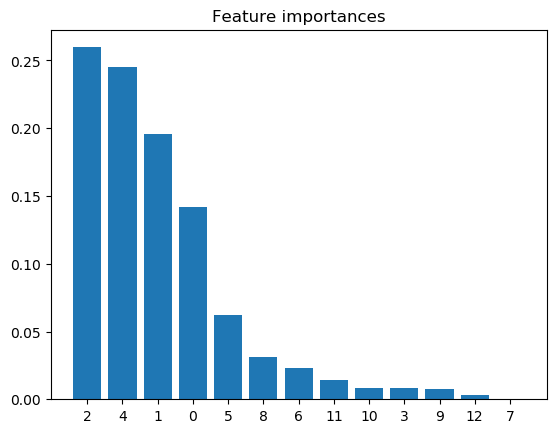

In [25]:
# get feature importances
tree_importances = tree_clf.feature_importances_

# sort feature importances in descending order
indices = np.argsort(tree_importances)[::-1]

# print out the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[f], tree_importances[indices[f]]))

# plot the feature importances
plt.title("Feature importances")
plt.bar(range(X.shape[1]), tree_importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.show()

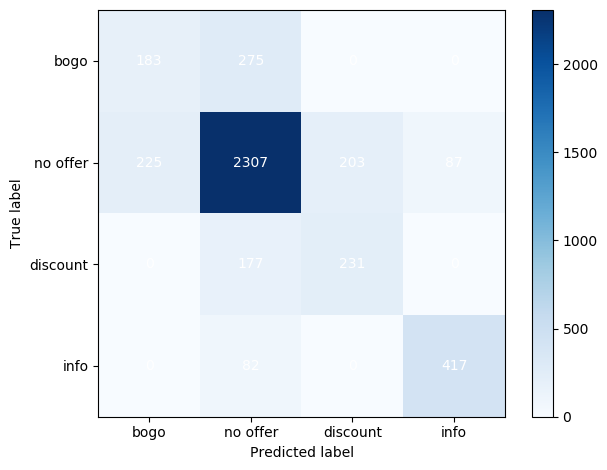

In [27]:
# Compute the confusion matrix
tree_cm = confusion_matrix(y_val, tree_pred)

# Visualize the confusion matrix as a heatmap
fig, ax = plt.subplots()
im = ax.imshow(tree_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(tree_cm.shape[1]),
       yticks=np.arange(tree_cm.shape[0]),
       xticklabels=['bogo', 'no offer', 'discount', 'info'],
       yticklabels=['bogo', 'no offer', 'discount', 'info'],
       xlabel='Predicted label',
       ylabel='True label')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Loop over data to add annotations
for i in range(tree_cm.shape[0]):
    for j in range(tree_cm.shape[1]):
        ax.text(j, i, tree_cm[i, j], ha="center", va="center", color="white")

fig.tight_layout()
plt.show()

In [28]:
forest_clf = RandomForestClassifier(max_depth=2, random_state=0)
forest_clf = forest_clf.fit(X_train, y_train)

In [29]:
forest_pred = forest_clf.predict(X_val)

In [30]:
forest_f1 = f1_score(forest_pred, y_val, average = "weighted")

In [31]:
print(forest_f1)

0.8426401748435064


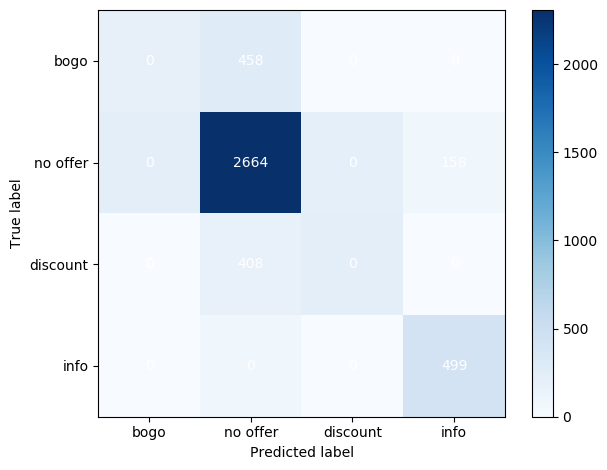

In [33]:
# Compute the confusion matrix
forest_cm = confusion_matrix(y_val, forest_pred)

# Visualize the confusion matrix as a heatmap
fig, ax = plt.subplots()
im = ax.imshow(tree_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(forest_cm.shape[1]),
       yticks=np.arange(forest_cm.shape[0]),
       xticklabels=['bogo', 'no offer', 'discount', 'info'],
       yticklabels=['bogo', 'no offer', 'discount', 'info'],
       xlabel='Predicted label',
       ylabel='True label')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Loop over data to add annotations
for i in range(forest_cm.shape[0]):
    for j in range(forest_cm.shape[1]):
        ax.text(j, i, forest_cm[i, j], ha="center", va="center", color="white")

fig.tight_layout()
plt.show()

Feature ranking:
1. feature 4 age (0.283364)
2. feature 5 income (0.257761)
3. feature 3 membership_duration (0.234630)
4. feature 1 difficulty (0.097992)
5. feature 6 duration (0.047045)
6. feature 2 reward (0.031239)
7. feature 8 web (0.017431)
8. feature 9 email (0.016229)
9. feature 10 social (0.007582)
10. feature 11 mobile (0.006337)
11. feature 0 gender = _F (0.000382)
12. feature 12 gender = _M (0.000009)
13. feature 7 gender = _O (0.000000)


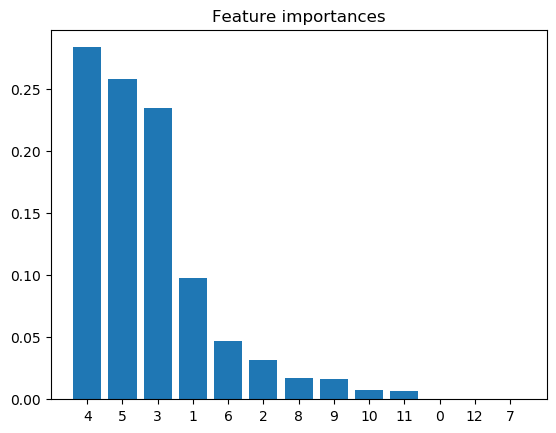

In [34]:
# get feature importances
forest_importances = forest_clf.feature_importances_

# sort feature importances in descending order
indices = np.argsort(forest_importances)[::-1]

# print out the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[f], forest_importances[indices[f]]))

# plot the feature importances
plt.title("Feature importances")
plt.bar(range(X.shape[1]), forest_importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.show()


In [37]:
lgb_clf = lgb.LGBMClassifier()
lgb_clf = lgb_clf.fit(X_train, y_train)

In [38]:
lgb_pred = lgb_clf.predict(X_val)

In [39]:
lgb_f1 = f1_score(lgb_pred, y_val, average = "weighted")

In [40]:
print(lgb_f1)

0.8207744367514276


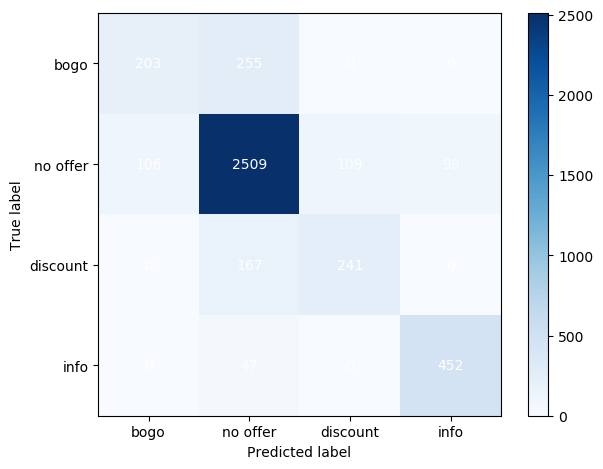

In [42]:
# Compute the confusion matrix
lgb_cm = confusion_matrix(y_val, lgb_pred)

# Visualize the confusion matrix as a heatmap
fig, ax = plt.subplots()
im = ax.imshow(lgb_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(lgb_cm.shape[1]),
       yticks=np.arange(lgb_cm.shape[0]),
       xticklabels=['bogo', 'no offer', 'discount', 'info'],
       yticklabels=['bogo', 'no offer', 'discount', 'info'],
       xlabel='Predicted label',
       ylabel='True label')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Loop over data to add annotations
for i in range(lgb_cm.shape[0]):
    for j in range(lgb_cm.shape[1]):
        ax.text(j, i, lgb_cm[i, j], ha="center", va="center", color="white")

fig.tight_layout()
plt.show()

Feature ranking:
1. feature 2 age (4098.000000)
2. feature 1 income (3048.000000)
3. feature 0 membership_duration (2855.000000)
4. feature 3 difficulty (526.000000)
5. feature 4 duration (357.000000)
6. feature 5 reward (297.000000)
7. feature 8 web (245.000000)
8. feature 11 email (218.000000)
9. feature 10 social (208.000000)
10. feature 6 mobile (80.000000)
11. feature 12 gender = _F (50.000000)
12. feature 9 gender = _M (18.000000)
13. feature 7 gender = _O (0.000000)


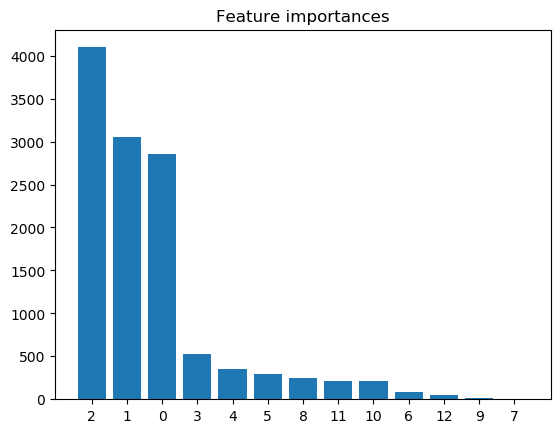

In [43]:
# get feature importances
lgb_importances = lgb_clf.feature_importances_

# sort feature importances in descending order
indices = np.argsort(lgb_importances)[::-1]

# print out the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[f], lgb_importances[indices[f]]))

# plot the feature importances
plt.title("Feature importances")
plt.bar(range(X.shape[1]), lgb_importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.show()

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

In [49]:
models = []
models.append(('DT', tree.DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('LGBM', lgb.LGBMClassifier()))

In [50]:
f1_results = []
f1_names = []
scoring = 'f1_weighted'
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for name, model in models:
    trans = StandardScaler()
    pipeline = Pipeline(steps=[('t', trans), ('m', model)])
    cv_results = cross_val_score(pipeline, 
                                    X_train, 
                                    y_train, 
                                    scoring = scoring, 
                                    cv = cv)
    f1_results.append(abs(cv_results))
    f1_names.append(name)
    msg = "%s: %f (%f)" % (name, abs(cv_results.mean()), cv_results.std())
    print(abs(cv_results), msg)

[0.75018084 0.75298501 0.74762238 0.74660143 0.76383142 0.74047729
 0.73646855 0.77478536 0.75021532 0.74504383] DT: 0.750821 (0.010599)
[0.79992746 0.77689687 0.81051854 0.78876035 0.80905555 0.79795422
 0.80614609 0.80913039 0.779773   0.79557567] RF: 0.797374 (0.011566)
[0.79463725 0.79349725 0.8163661  0.80603795 0.80417958 0.812584
 0.81123295 0.81763935 0.79184064 0.79198643] LGBM: 0.804000 (0.009794)


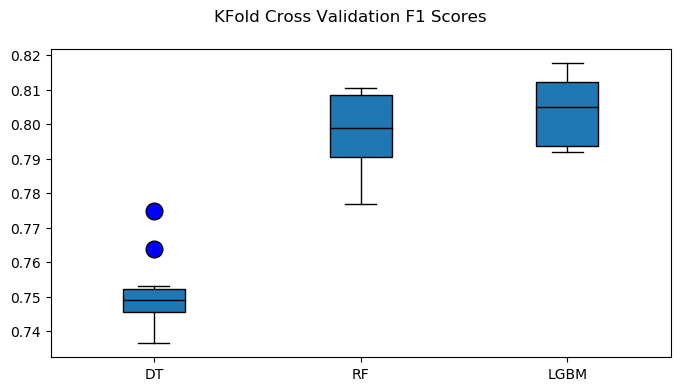

In [54]:
fig = plt.figure(figsize=(8,4))
fig.suptitle('KFold Cross Validation F1 Scores', color = 'black')
ax = fig.add_subplot(111)

plt.boxplot(f1_results, vert = True, patch_artist = True, manage_ticks = True,
            medianprops = {"color":'black'}, 
            whiskerprops = {"color": 'black'}, 
            capprops = {"color": 'black'}, 
            boxprops = {"color": 'black'}, 
            flierprops = {"marker":'o', 
                          "markerfacecolor":'b', 
                          "markersize": 12})

ax.set_xticklabels(f1_names)

plt.show()

# plt.savefig(os.path.join('photos/kfold_f1_weighted.png'), dpi=300, format='png', bbox_inches='tight') 


In [78]:
params = {'max_depth': [24,26,28],
          'num_leaves': [80, 90, 100],
          'min_data_in_leaf': [200, 500, 900]}

In [79]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
lgb = lgb.LGBMClassifier()

clf = RandomizedSearchCV(estimator=lgb, 
                         param_distributions=params,
                         n_iter = 10,
                         scoring='f1_weighted',
                         cv = 10,
                         verbose=1)
clf.fit(X_val, y_val)
print("Best parameters:", clf.best_params_)
print("Best F1 Score: ", (clf.best_score_))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGB

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.4s finished


In [ ]:
# Best parameters: {'num_leaves': 256, 'min_data_in_leaf': 300, 'max_depth': 9}
# Best F1 Score:  0.8093846535417842
# Best parameters: {'num_leaves': 512, 'min_data_in_leaf': 500, 'max_depth': 14}
# Best F1 Score:  0.8053094260508817
# Best parameters: {'num_leaves': 70, 'min_data_in_leaf': 500, 'max_depth': 14}
# Best F1 Score:  0.8053094260508817
# Best parameters: {'num_leaves': 70, 'min_data_in_leaf': 500, 'max_depth': 16}
# Best F1 Score:  0.8053094260508817
# Best parameters: {'num_leaves': 80, 'min_data_in_leaf': 200, 'max_depth': 16}
# Best F1 Score:  0.80599093248161
# Best parameters: {'num_leaves': 80, 'min_data_in_leaf': 200, 'max_depth': 16}
# Best F1 Score:  0.80599093248161
# Best parameters: {'num_leaves': 80, 'min_data_in_leaf': 200, 'max_depth': 22}
# Best F1 Score:  0.80599093248161
# Best parameters: {'num_leaves': 100, 'min_data_in_leaf': 200, 'max_depth': 26}
# Best F1 Score:  0.80599093248161
# Best parameters: {'num_leaves': 100, 'min_data_in_leaf': 200, 'max_depth': 28}
# Best F1 Score:  0.80599093248161

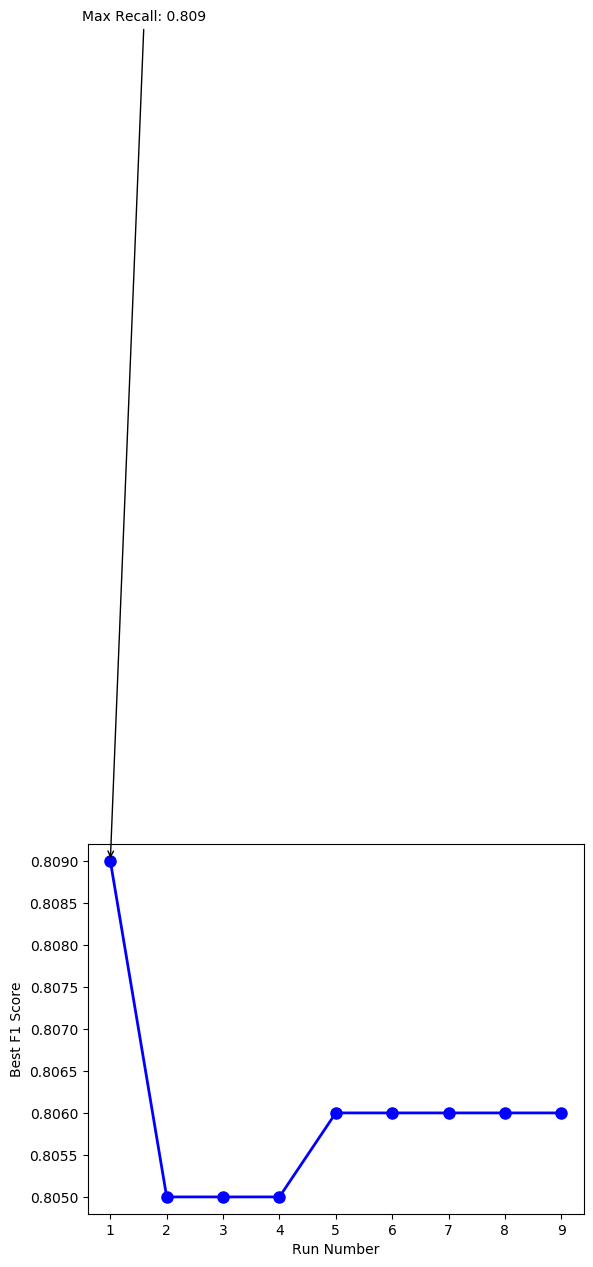

In [146]:
import matplotlib.pyplot as plt

best_recall = [0.809, 0.805, 0.805, 0.805, 0.806, 0.806, 0.806, 0.806, 0.806]
runs = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the line graph
ax.plot(runs, best_recall, '-o', color='blue', linewidth=2, markersize=8)

# Add text annotation for the highest value
max_recall = max(best_recall)
max_run = runs[best_recall.index(max_recall)]
ax.annotate(f'Max Recall: {max_recall:.3f}', xy=(max_run, max_recall), xytext=(max_run-0.5, max_recall+0.01),
            arrowprops=dict(facecolor='black', arrowstyle='->'))

# Set axis labels and title
ax.set_xlabel('Run Number')
ax.set_ylabel('Best F1 Score')

# Show the plot
plt.show()

In [147]:
import lightgbm as lgb
best_lgb = lgb.LGBMClassifier(num_leaves = 256, min_data_in_leaf = 300, max_depth = 9)
best_lgb.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=9,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=300, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=256, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [83]:
best_pred = best_lgb.predict(X_test)

In [84]:
best_pred

array([1, 3, 3, ..., 2, 0, 1])

In [85]:
best_pred_df = pd.DataFrame({'actual': y_test, 'predicted': best_pred})


In [86]:
best_pred_df = pd.merge(left = best_pred_df, right = X_test, how = "inner" , left_on = best_pred_df.index, right_on=X_test.index)

In [89]:
best_pred_df

,key_0,actual,predicted,age,income,membership_duration,difficulty,duration,reward,web,email,social,mobile,gender = _F,gender = _M,gender = _O
0,4127,1,1,31,51000.0,41,5,5,5,1,1,1,1,0,1,0
1,7935,3,3,49,99000.0,985,0,3,0,0,1,1,1,1,0,0
2,391,1,3,70,92000.0,259,0,4,0,1,1,0,1,1,0,0
3,6319,1,1,37,45000.0,91,5,5,5,1,1,1,1,1,0,0
4,11693,1,0,92,65000.0,866,10,5,10,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4183,10354,3,3,51,63000.0,1530,0,3,0,0,1,1,1,0,1,0
4184,12784,1,1,72,47000.0,96,0,4,0,1,1,0,1,0,1,0
4185,3442,2,2,53,75000.0,700,10,10,2,1,1,1,1,1,0,0
4186,18783,0,0,88,78000.0,970,5,5,5,1,1,1,1,1,0,0


In [87]:
best_pred_df.shape

(4188, 16)

In [88]:
# best_pred_df.to_csv('usertype_results.csv', index = False)

In [92]:
best_pred_df = pd.read_csv('usertype_results.csv')

In [93]:
best_pred_df

,key_0,actual,predicted,age,income,membership_duration,difficulty,duration,reward,web,email,social,mobile,gender = _F,gender = _M,gender = _O
0,4127,1,1,31,51000.0,41,5,5,5,1,1,1,1,0,1,0
1,7935,3,3,49,99000.0,985,0,3,0,0,1,1,1,1,0,0
2,391,1,3,70,92000.0,259,0,4,0,1,1,0,1,1,0,0
3,6319,1,1,37,45000.0,91,5,5,5,1,1,1,1,1,0,0
4,11693,1,0,92,65000.0,866,10,5,10,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4183,10354,3,3,51,63000.0,1530,0,3,0,0,1,1,1,0,1,0
4184,12784,1,1,72,47000.0,96,0,4,0,1,1,0,1,0,1,0
4185,3442,2,2,53,75000.0,700,10,10,2,1,1,1,1,1,0,0
4186,18783,0,0,88,78000.0,970,5,5,5,1,1,1,1,1,0,0


In [101]:
# Create age groups by rounding down to the nearest 20
# best_pred_df['age_group'] = (best_pred_df['age'] // 20) * 20

# # Create a list of unique age groups in the DataFrame, sorted in ascending order
# age_groups = sorted(best_pred_df['age_group'].unique())

# # Create a dictionary to map predicted values to labels for the pie charts
# labels_dict = {0: 'BOGO Buyers', 1: 'Buy Without Offers', 2: 'Discount Buyers', 3: 'Informational Buyers'}

# # Create a pie chart for each age group and predicted value
# for age_group in age_groups:
#     # Get the subset of the DataFrame for the current age group
#     subset = best_pred_df[best_pred_df['age_group'] == age_group]
    
#     # Count the number of occurrences of each predicted value in the subset
#     counts = subset['predicted'].value_counts()
    
#     # Create a pie chart
#     plt.figure()
#     plt.pie(counts, labels=[labels_dict.get(x, '') for x in counts.index], autopct='%1.1f%%')
#     plt.title('Age Group: {} - {}'.format(age_group, age_group+19))
#     plt.axis('equal')
#     plt.savefig(os.path.join(f'photos/result_user_types_{age_group}.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

# plt.show()

In [105]:
# # Define the minimum and maximum income values
# min_income = min(best_pred_df['income'])
# max_income = max(best_pred_df['income'])

# # Define the number of income groups
# num_income_groups = 6

# # Calculate the income range for each group
# income_range = (max_income - min_income) / num_income_groups

# # Create income groups by rounding down to the nearest income range
# best_pred_df['income_group'] = (best_pred_df['income'] // income_range) * income_range

# # Create a list of unique income groups in the DataFrame, sorted in ascending order
# income_groups = sorted(best_pred_df['income_group'].unique())

# # Create a dictionary to map predicted values to labels for the pie charts
# labels_dict = {0: 'BOGO Buyers', 1: 'Buy Without Offers', 2: 'Discount Buyers', 3: 'Informational Buyers'}

# # Create a pie chart for each income group and predicted value
# for income_group in income_groups:
#     # Get the subset of the DataFrame for the current income group
#     subset = best_pred_df[best_pred_df['income_group'] == income_group]
    
#     # Count the number of occurrences of each predicted value in the subset
#     counts = subset['predicted'].value_counts()
    
#     # Create a pie chart
#     plt.figure()
#     plt.pie(counts, labels=[labels_dict.get(x, '') for x in counts.index], autopct='%1.1f%%')
#     plt.title('Income Group: {} - {}'.format(income_group, income_group+income_range))
#     plt.axis('equal')
#     plt.savefig(os.path.join(f'photos/result_user_types_{income_group}.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


# plt.show()


In [106]:
min(best_pred_df['income'])

30000.0

In [107]:
max(best_pred_df['income'])

120000.0

In [108]:
min(best_pred_df['membership_duration'])

0

In [109]:
max(best_pred_df['membership_duration'])

1819

In [121]:
# # Define the minimum and maximum membership duration values
# min_duration = min(best_pred_df['membership_duration'])
# max_duration = max(best_pred_df['membership_duration'])

# # Define the number of membership duration groups
# num_duration_groups = 6

# # Calculate the membership duration range for each group
# duration_range = (max_duration - min_duration) / num_duration_groups

# # Create membership duration groups by rounding down to the nearest income range
# best_pred_df['duration_group'] = (best_pred_df['membership_duration'] // duration_range) * duration_range

# # Create a list of unique duration groups in the DataFrame, sorted in ascending order
# duration_groups = sorted(best_pred_df['duration_group'].unique())

# # Create a dictionary to map predicted values to labels for the pie charts
# labels_dict = {0: 'BOGO Buyers', 1: 'Buy Without Offers', 2: 'Discount Buyers', 3: 'Informational Buyers'}

# # Create a pie chart for each duration group and predicted value
# for duration_group in duration_groups:
#     # Get the subset of the DataFrame for the current income group
#     subset = best_pred_df[best_pred_df['duration_group'] == duration_group]
    
#     # Count the number of occurrences of each predicted value in the subset
#     counts = subset['predicted'].value_counts()
    
#     # Create a pie chart
#     plt.figure()
#     plt.pie(counts, labels=[labels_dict.get(x, '') for x in counts.index], autopct='%1.1f%%')
#     plt.title('Duration Group: {} - {}'.format(round(duration_group), (round(duration_group+duration_range)-1)))
#     plt.axis('equal')
#     # plt.savefig(os.path.join(f'photos/result_user_types_duration_{duration_group}.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


# plt.show()

In [125]:
# Create a dictionary to map predicted values to labels for the pie charts
labels_dict = {0: 'BOGO Buyers', 1: 'Buy Without Offers', 2: 'Discount Buyers', 3: 'Informational Buyers'}

# Round off the membership duration column to the nearest integer
best_pred_df['membership_duration'] = best_pred_df['membership_duration'].round()

# Define the minimum and maximum membership duration values
min_duration = min(best_pred_df['membership_duration'])
max_duration = max(best_pred_df['membership_duration'])

# Define the number of membership duration groups
num_duration_groups = 6

# Calculate the membership duration range for each group
duration_range = (max_duration - min_duration) / num_duration_groups

# Create membership duration groups by rounding down to the nearest income range
best_pred_df['duration_group'] = (best_pred_df['membership_duration'] // duration_range) * duration_range

# Create a list of unique duration groups in the DataFrame, sorted in ascending order
duration_groups = sorted(best_pred_df['duration_group'].unique())

# Create a pie chart for each duration group and predicted value
for duration_group in duration_groups:
    # Get the subset of the DataFrame for the current duration group
    subset = best_pred_df[best_pred_df['duration_group'] == duration_group]
    
    # Count the number of occurrences of each predicted value in the subset
    counts = subset['predicted'].value_counts()
    
    # Round off the title values to the nearest integer
    duration_group_title = round(duration_group)
    duration_group_range_title = round(duration_group + duration_range)
    
    # Create a pie chart
    plt.figure()
    plt.pie(counts, labels=[labels_dict.get(x, '') for x in counts.index], autopct='%1.1f%%')
    plt.title('Duration Group: {} - {}'.format(duration_group_title, duration_group_range_title))
    plt.axis('equal')
    # plt.savefig(os.path.join(f'photos/result_user_types_duration_{duration_group}.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


plt.show()



In [128]:
# Create a dictionary to map predicted values to labels for the pie charts
labels_dict = {0: 'BOGO Buyers', 1: 'Buy Without Offers', 2: 'Discount Buyers', 3: 'Informational Buyers'}

# Group the data by predicted value and sum the male, female, and other columns
counts = best_pred_df.groupby('predicted')[['gender = _M', 'gender = _F', 'gender = _O']].sum()

# Create a stacked bar chart
counts.plot(kind='bar')

# Set the title and axis labels
plt.title('Number of Users by Predicted User Type and Gender')
plt.xlabel('Predicted User Type')
plt.ylabel('Count')

# Set the legend for the chart
plt.legend(title='Gender', labels=['Male', 'Female', 'Other'])

# plt.show()

plt.savefig(os.path.join(f'photos/result_user_types_gender.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures



In [137]:
# Map predicted values to labels
# Create a dictionary to map predicted values to labels for the pie charts
labels_dict = {0: 'BOGO', 2: 'Discount', 3: 'Info'}
best_pred_df['predicted_label'] = best_pred_df['predicted'].map(labels_dict)

# Create box and whisker plots
# sns.boxplot(x='predicted_label', y='duration', data=best_pred_df)
# plt.title('Duration')
# plt.xlabel('User Type')
# plt.ylabel('Duration')
# # plt.show()
# plt.savefig(os.path.join(f'photos/user_duration.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


# sns.boxplot(x='predicted_label', y='difficulty', data=best_pred_df)
# plt.title('Difficulty')
# plt.xlabel('User Type')
# plt.ylabel('Difficulty')
# # plt.show()
# plt.savefig(os.path.join(f'photos/user_difficulty.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


# sns.boxplot(x='predicted_label', y='reward', data=best_pred_df)
# plt.title('Reward')
# plt.xlabel('User Type')
# plt.ylabel('Reward')
# # plt.show()
# plt.savefig(os.path.join(f'photos/user_reward.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


In [138]:
best_pred_df.columns

Index(['key_0', 'actual', 'predicted', 'age', 'income', 'membership_duration',
       'difficulty', 'duration', 'reward', 'web', 'email', 'social', 'mobile',
       'gender = _F', 'gender = _M', 'gender = _O', 'age_group',
       'income_group', 'duration_group', 'predicted_label'],
      dtype='object')

In [139]:
best_f1 = f1_score(y_test, best_pred, average = 'weighted')
print(best_f1)

0.8055389792331826


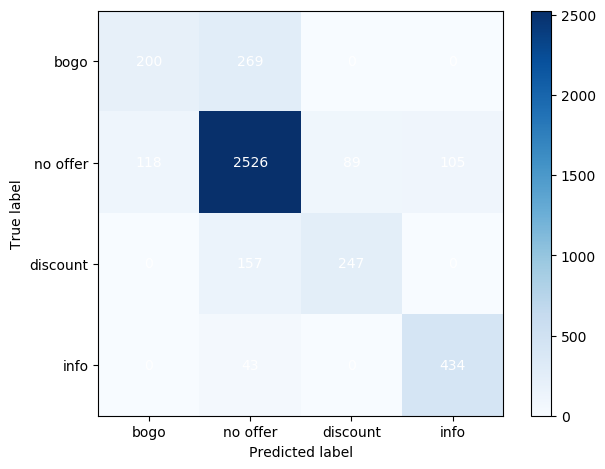

In [141]:
# Compute the confusion matrix
best_cm = confusion_matrix(y_test, best_pred)

# Visualize the confusion matrix as a heatmap
fig, ax = plt.subplots()
im = ax.imshow(best_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(best_cm.shape[1]),
       yticks=np.arange(best_cm.shape[0]),
       xticklabels=['bogo', 'no offer', 'discount', 'info'],
       yticklabels=['bogo', 'no offer', 'discount', 'info'],
       xlabel='Predicted label',
       ylabel='True label')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Loop over data to add annotations
for i in range(best_cm.shape[0]):
    for j in range(best_cm.shape[1]):
        ax.text(j, i, best_cm[i, j], ha="center", va="center", color="white")

fig.tight_layout()
plt.show()

Feature ranking:
1. feature 2 age (3221.000000)
2. feature 1 income (2632.000000)
3. feature 0 membership_duration (1760.000000)
4. feature 3 difficulty (740.000000)
5. feature 4 duration (558.000000)
6. feature 8 reward (410.000000)
7. feature 11 web (356.000000)
8. feature 5 email (320.000000)
9. feature 10 social (138.000000)
10. feature 6 mobile (25.000000)
11. feature 9 gender = _F (2.000000)
12. feature 12 gender = _M (0.000000)
13. feature 7 gender = _O (0.000000)


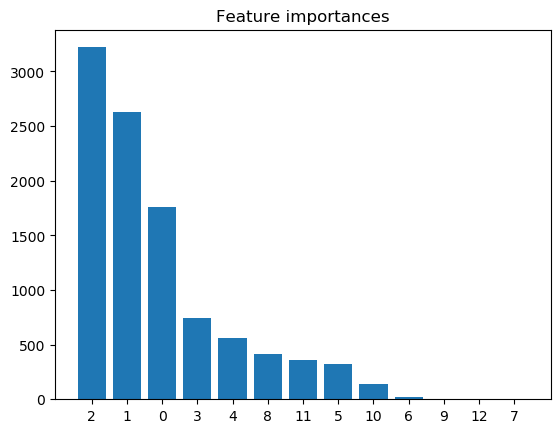

In [143]:
# get feature importances
best_importances = best_lgb.feature_importances_

# sort feature importances in descending order
indices = np.argsort(best_importances)[::-1]

# print out the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[f], best_importances[indices[f]]))

# plot the feature importances
plt.title("Feature importances")
plt.bar(range(X.shape[1]), best_importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.show()